In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode

## COMPUTING SYSTEM PERFORMANCE HISTOGRAM

In [2]:
def load_database(csv_path):
    database = pd.read_csv(csv_path)
    print(f"Number of samples: {len(database)}")
    print(f"Mean WER%: {database['wer'].mean()}")
    
    return database

def wer_bin_hist(database):
    hist_wers = database["wer"].value_counts(bins=[0,10,20,30,40,50,60,70,80,90,100,300])
    hist_wers.sort_index(ascending=True, inplace=True)
    return hist_wers

def nwords_bin(database):
    bin_bounds = [(-1, 10)] + list(zip(range(10,100+1,10), range(20,100+1,10)))        
    nwords = {}
    for i,j in bin_bounds:
        werbin = database[(database["wer"]>i) & (database["wer"]<=j)]
        nwords[f"({i}:{j}]"] = round(werbin["nwords"].mean(), 1)
    
    return nwords    

In [3]:
database = load_database("./uff/liprtve-si/inference/test.stats")
wer_hist = wer_bin_hist(database)
nword_hist = nwords_bin(database)

Number of samples: 1572
Mean WER%: 59.5779262086514


### COMPUTING ZIPF'S LAW

In [4]:
def compute_zipf_law(database, scenario, datasets, enc):
    splits_dir = "../data/" + database + "/splits/" + scenario + "/"
    transcriptions_path = "../data/" + database + "/transcriptions/"

    cont = 0
    word_freq = {}
    for dataset_name in datasets:
        dataset_path = os.path.join(splits_dir, dataset_name+database+".csv")
        dataset = pd.read_csv(dataset_path)["sampleID"].tolist()

        for sampleID in dataset:
            spkrID = sampleID.split("_")[0]
            transcription_path = os.path.join(transcriptions_path, spkrID, sampleID+".txt")
            transcription = open(transcription_path, "r", encoding=enc).readlines()[0].strip().lower()
            clean_transcription = transcription.replace("{", "").replace("}", "") 
            # clean_transcription = unidecode(clean_transcription.replace("ñ", "N")).replace("N", "ñ")

            for word in clean_transcription.split():
                if word_freq.get(word) is None:
                    word_freq[word] = 1
                else:
                    word_freq[word] += 1             

    return dict(sorted(word_freq.items(), key=lambda elem: elem[1], reverse=True))

def compute_ranks(word_freq):
    word_rank = {}
    top_count = 0
    for idx, (word, frequency) in enumerate(list(word_freq.items())):
            if idx == 0:
                top_count = frequency
            word_rank[word] = frequency/top_count
    return word_rank

def zipf_to_csv(dest_path, vocabulary_ranks, zipf_law, database_rank, database_freq, database_words):
    with open(dest_path, "w") as f:
        f.write(f"vocab_id,zipf_law,database_rank,database_freq,database_word\n")
        for vocab, zipf_rank, data_rank, data_freq, data_word in zip(vocabulary_ranks, zipf_law, database_rank, database_freq, database_words):
            f.write(f"{vocab},{zipf_rank},{data_rank},{data_freq},{data_word}\n")

def compare_to_zipf_law_plot(database, word_freq, word_rank, dest_path):
    vocabulary_ranks = np.arange(len(word_freq)) + 1

    zipf_law = np.array([float(1/r) for r in range(1, len(word_freq)+1)]) # [1/1, 1/2, 1/3, 1/4, ...]
    database_law = word_rank.values() # the actual rank computed based on the database

    zipf_to_csv(dest_path, vocabulary_ranks, zipf_law, database_law, list(word_freq.values()), list(word_freq.keys()))
    
    fig, ax = plt.subplots()
    ax.loglog(vocabulary_ranks, zipf_law, label="Zipf's law")
    ax.loglog(vocabulary_ranks, database_law, label=database.upper())
    ax.set_xlabel('vocabulary rank')
    ax.set_ylabel('frequency')
    ax.legend()
    None

[('the', 180512), ('and', 141369), ('to', 139741)]

[('the', 1.0), ('and', 0.7831556904804112), ('to', 0.7741368994859068)]


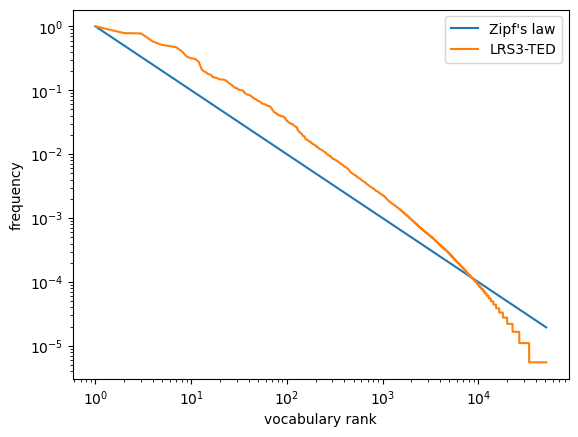

In [13]:
word_freq = compute_zipf_law("LRS3-TED", "speaker-independent", ["fulltrain", "test"], "utf-8")
word_rank = compute_ranks(word_freq)

print(list(word_freq.items())[:3]); print(); print(list(word_rank.items())[:3])

compare_to_zipf_law_plot("LRS3-TED", word_freq, word_rank, "complete_zipf_lrs3.csv")

[('de', 42), ('la', 34), ('el', 28)]

[('de', 1.0), ('la', 0.8095238095238095), ('el', 0.6666666666666666)]


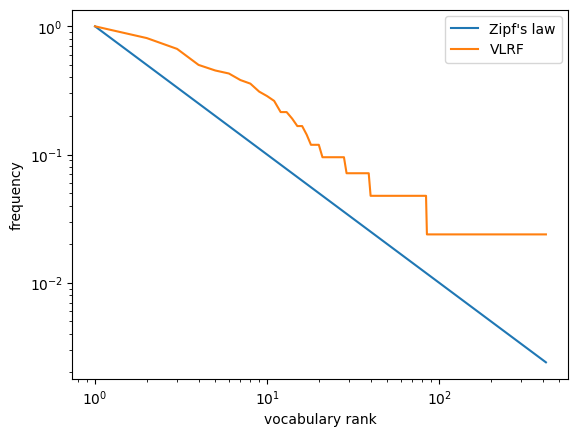

In [5]:
word_freq = compute_zipf_law("VLRF", "speaker-dependent", ["fulltrain", "test"], "ISO-8859-1")
word_rank = compute_ranks(word_freq)

print(list(word_freq.items())[:3]); print(); print(list(word_rank.items())[:3])

compare_to_zipf_law_plot("VLRF", word_freq, word_rank, "complete_zipf_vlrf.csv")

[('de', 1342), ('que', 772), ('la', 768)]

[('de', 1.0), ('que', 0.5752608047690015), ('la', 0.5722801788375559)]


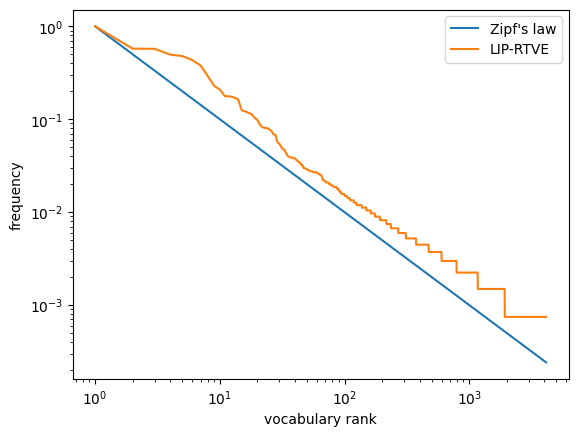

In [10]:
word_freq = compute_zipf_law("LIP-RTVE", "speaker-dependent", ["test"], "utf-8")
word_rank = compute_ranks(word_freq)

print(list(word_freq.items())[:3]); print(); print(list(word_rank.items())[:3])

compare_to_zipf_law_plot("LIP-RTVE", word_freq, word_rank, "test-sd_zipf_liprtve.csv")

In [76]:
!wc -l complete_zipf_liprtve.csv

9309 complete_zipf_liprtve.csv
